In [1]:
import numpy as np
from numpy.linalg import LinAlgError
np.random.seed(1)

from scipy.optimize import minimize
import matplotlib.pyplot as plt

from time import time

import jax
jax.config.update("jax_enable_x64", True)  # We need double precision in automatic differentiation.

from plaingaussian.normal import normal, stack
from plaingaussian.parametric import pnormal

# Laser thansmission through a cavity with frequency noise

When a laser beam is coupled to an optical cavity, and the transmission through the cavity is being recorded using a photodide, the signal on the photodiode can be described by the equation
$$I(t) = \frac{a}{1+(\Delta(t)/\kappa)^2} + \xi(t),$$
where $a$ and $\kappa$ are the resonance amplitude and linewidth, $\xi(t)$ is the detection noise, and $\Delta(t)=\omega_L(t)-\omega_c(t)$ is the laser-cavity frequency detuning.

Below we compose a model describing the situation when the detection noise is white, $\langle \xi(t)\xi(t+\tau)\propto \delta(\tau)$, the laser frequency is linearly scanned, $\omega_L\propto t$, while the cavity frequency undergoes Brownian motion, $\langle \omega_c(t)\omega_c(t+\tau)\propto |\tau|$. 


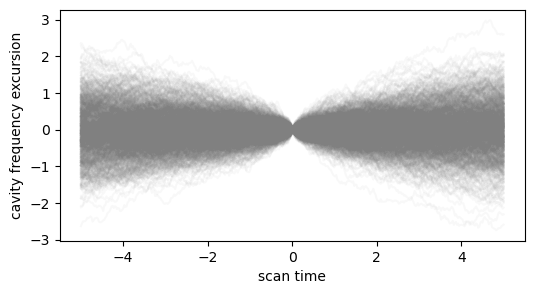

In [2]:
# We assume that the data is centered, i. e. at x=0 the cavity frequency is zero.

npts = 4 * 10**2
x = np.linspace(-5, 5, npts)

freq = [None] * npts
freq[0] = normal(0, 100)  # the unknown initial state
for i in range(npts-1):
    freq[i+1] = freq[i] + normal(0, 1/(npts-1))

freqs = stack(freq) | {freq[npts//2]: 0}

nsample = 10**3
samples = freqs.sample(nsample)

_ = plt.figure(figsize=(6, 3))
plt.plot(x, samples.T, alpha=0.05, color='gray')
plt.xlabel("scan time")
plt.ylabel("cavity frequency excursion");

Next we make a model for the cavity transmission, also adding the detection noise.

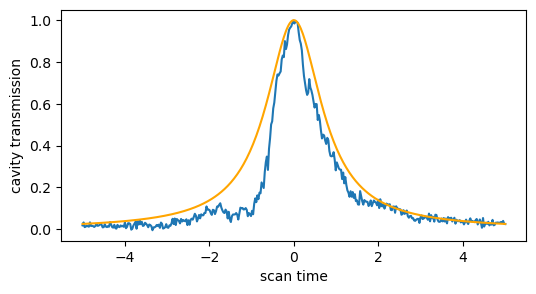

In [3]:
def lorentzian(x):
    return 1./(1. + x**2)


def lorentzian_model(a, lw, sigf, sigm):
    """Cavity transmission model.

    Args:
        a: amplitude
        lw: linewidth 
        sigf: magnitude of the frequency noise
        sigm: magnitude of the detection noise    
    """
    return a * lorentzian((sigf * freqs + x)/lw) + sigm * mn


mn = normal(0, 1, size=npts)  # detection noise

p_true = (1, 0.8, 0.9, 0.01)  # "true" parameters
tm = lorentzian_model(*p_true)

_ = plt.figure(figsize=(6, 3))
plt.plot(x, tm.sample().T);
plt.plot(x, lorentzian(x/0.8), color='orange')
plt.xlabel("scan time")
plt.ylabel("cavity transmission");

The introduced `lorentzian_model` is linearized with respect to all the random variables. It therefore has some linearization error, which we can see by comparing sampling from it with exact sampling. When the noises are small enough, this error is negligible.

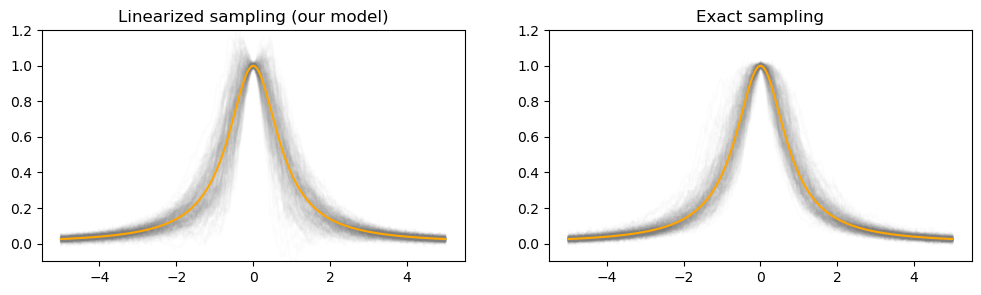

In [4]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 3))
ax1.plot(x, tm.sample(2 * 10**2).T, alpha=0.02, color='gray')
ax1.plot(x, lorentzian(x/0.8), color='orange')
ax1.set_ylim(-0.1, 1.2)
ax1.set_title("Linearized sampling (our model)")

ax2.plot(x, (lorentzian((0.7 * freqs + x).sample(2 * 10**2)/0.8) + 0.01 * mn.sample(2 * 10**2)).T, alpha=0.02, color='gray');
ax2.plot(x, lorentzian(x/0.8), color='orange')
ax2.set_ylim(-0.1, 1.2)
ax2.set_title("Exact sampling");

# Maximum likelihood fitting

Suppose that we have one sample from the distribution describing noisy cavity transmissions (which could be obtained from an experiment), and we would like to estimate the parameters of the distribution from it. This can be done by maximizing the likelihood of the sample over the parameters, i.e., via maximum-likelihood fitting.

In [5]:
y = tm.sample()  # the sample

we can implement numerical fitting using scipy minimize

In [6]:
def cross_entropy(args):
    model = lorentzian_model(*args)
    return -model.logp(y)

p0 = np.array([0., 1.5, 1, 1])  # initial point

t0 = time()
min_sol1 = minimize(cross_entropy, p0)
print(f"Solution time: {time() - t0:.3g} s")
print(f"Optimum parameters: {min_sol1['x']}")
print(f"Relative errors: {(np.abs(min_sol1['x'])-p_true)/p_true}")

Solution time: 5.95 s
Optimum parameters: [ 0.9995719   0.85466144  0.91775366 -0.00949785]
Relative errors: [-0.0004281   0.0683268   0.01972629 -0.05021485]


The solution in this case is ok. The optimizer, however, complains about the precision loss due to numeric differentiation.

In [7]:
min_sol1['message']

'Desired error not necessarily achieved due to precision loss.'

# Fitting with gradients

We can help the fitting by explicitly supplying gradients. For this purpose, we create a version of the model function that now takes the random variables as explicit argument,

In [8]:
def lorentzian_model_(params, variables):
    a, lw, sigf, sigm = params
    xis, mn = variables
    return a * lorentzian((sigf * xis + x)/lw) + sigm * mn

and create a parametric normal random variable using `pnormal`

In [9]:
model = pnormal(lorentzian_model_, [freqs, mn])

def cross_entropy(args):
    f = -model.logp(args, y)
    g = -model.dlogp(args, y) 
    return (f, g)

t0 = time()
min_sol2 = minimize(cross_entropy, (0, 1.5, 1, 1), jac=True)
print(f"Solution time: {time() - t0:.3g} s")
print(f"Optimum parameters: {min_sol2['x']}")
print(f"Relative errors: {(np.abs(min_sol2['x'])-p_true)/p_true}")

Solution time: 5.96 s
Optimum parameters: [0.99957188 0.85466169 0.91775448 0.00949785]
Relative errors: [-0.00042812  0.06832711  0.0197272  -0.05021526]


# Natural gradient descent

Natural gradient descent exploits information geometry to speed up the optimization convergence. Natural gradient, $g_\mathrm{nat}$, is defined as the normal gradient multiplied by the inverse Fisher information matrix, that sets a metric in the parameter space, 
$$g_\mathrm{nat}(p)=F^{-1}\nabla \mathrm{ln}(p),$$
where $p$ is the parameter vector, and $F$ is the Fisher Information. 

Natural gradient descent can be implemented as follows using parametric distributions.

In [10]:
model = pnormal(lorentzian_model_, [freqs, mn])

nitermax = 100
p0 = (0., 1.5, 1, 1)
lr0 = 1.

lr = lr0  # current learning rate
p = p0  # current parameters

t0 = time()

logp_prev = model.logp(p, y)
completed = False

for i in range(nitermax):
    try:
        g = model.natdlogp(p, y)  # natural gradient
    except LinAlgError:
        g = model.dlogp(p, y)  # simle gradient, in the case if the Fisher 
                               # information matrix is degenerate

    while True:
        logp_new = model.logp(p + lr * g, y)

        if logp_prev < logp_new:
            p += lr * g  # accepts the step
            break
        else:
            if abs((logp_prev - logp_new)/logp_prev) < 1e-16:
                completed = True
                break

            lr = lr / 2

    if completed: break

    logp_prev = logp_new
    lr = lr0

print(f"Solution time: {time() - t0:.3g} s")
print(f"Final learning rate: {lr}, nit: {i+1}, logp: {logp_new}")

Solution time: 2.84 s
Final learning rate: 1.862645149230957e-09, nit: 18, logp: 1136.4905173030284


The natural gradient descent can also yield a better solution:

In [11]:
logp_new - (-min_sol1["fun"])

9.708855941426009e-11